## Imports

In [1]:
import findspark
findspark.init()

from pyspark import *
from pyspark.sql.functions import desc, col
from pyspark.sql import *
from graphframes import *

import os
from IPython.display import display, HTML
from src.graph_algorithms import JaccardSimilarity, LabelPropagationAlgorithm
from src.data_utils import read_data, read_meta
from src.viz_utils import plot_graph, plot_n_nodes_vs_degree

Auto-reload changes in py scripts.

In [2]:
%load_ext autoreload
%autoreload 2

Need to pass graphframes package to Spark, not pip.

In [3]:
# https://graphframes.github.io/graphframes/docs/_site/quick-start.html
# https://stackoverflow.com/questions/65011599/how-to-start-graphframes-on-spark-on-pyspark-on-juypter-on-docker
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

## Setup, Download and Read Data

Start Spark context.

In [4]:
spark = SparkSession.builder.appName('graphx-network-analysis').getOrCreate()

21/10/21 21:45:33 WARN Utils: Your hostname, mark-machine resolves to a loopback address: 127.0.1.1; using 192.168.0.102 instead (on interface wlp8s0)
21/10/21 21:45:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mark/.ivy2/cache
The jars for the packages stored in: /home/mark/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c3c45e55-fa3f-4283-898b-7862070a2f3d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 117ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------------------------------------

Download data.

Product co-purchasing networks by Amazon, availabel at http://snap.stanford.edu/data/#amazon

Directed edges in amazon0302, and meta-data in amazon-meta.

In [5]:
%%bash
file=./data/amazon0302.txt.gz
file_meta=./data/amazon-meta.txt.gz

if [ -e "$file" ]; then
    echo "$file exists, skipping"
else 
    echo "$file does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file
fi

if [ -e "$file_meta" ]; then
    echo "$file_meta exists, skipping"
else 
    echo "$file_meta does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file_meta
fi

./data/amazon0302.txt.gz exists, skipping
./data/amazon-meta.txt.gz exists, skipping


Read data, and build Pandas DataFrames for vertices, edges, and meta-data.

In [6]:
df_edges, df_vertices_no_meta = read_data(from_file_name="data/amazon0302.txt")
df_meta = read_meta(from_file_name="data/amazon-meta.txt")

display(HTML(df_edges.head(10).to_html()))
display(HTML(df_vertices_no_meta.head(10).to_html()))
display(HTML(df_meta.head(10).to_html()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 15010569/15010572 [00:15<00:00, 994562.72it/s]


,src,dst
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,1,0
6,1,2
7,1,4
8,1,5
9,1,15


,id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


,id,title,group,salesrank,reviews
0,1,Patterns of Preaching: A Sermon Sampler,book,396585,5.0
1,2,Candlemas: Feast of Flames,book,168596,4.5
2,3,World War II Allied Fighter Planes Trading Cards,book,1270652,5.0
3,4,Life Application Bible Commentary: 1 and 2 Timothy and Titus,book,631289,4.0
4,5,Prayers That Avail Much for Business: Executive,book,455160,0.0
5,6,How the Other Half Lives: Studies Among the Tenements of New York,book,188784,4.0
6,7,Batik,music,5392,4.5
7,8,Losing Matt Shepard,book,277409,4.5
8,9,Making Bread: The Taste of Traditional Home-Baking,book,949166,0.0
9,10,The Edward Said Reader,book,220379,4.0


## Building the Graph: From Pandas to GraphFrames

Convert Pandas DataFrames to Spark DataFrames.

In [7]:
# could take 1 min
vertices_no_meta = spark.createDataFrame(df_vertices_no_meta, list(df_vertices_no_meta.columns.values))
edges = spark.createDataFrame(df_edges, list(df_edges.columns.values))
meta = spark.createDataFrame(df_meta, list(df_meta.columns.values))

Inner join no-meta vertices table with meta-data table on id.

In [8]:
vertices = \
    vertices_no_meta.\
    join(meta, vertices_no_meta["id"] == meta["id"], "inner").\
    drop(meta.id)

vertices.show()

21/10/21 21:46:29 WARN TaskSetManager: Stage 0 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

Build GraphFrames graph from vertices and edges.

In [9]:
g = GraphFrame(vertices, edges)

g.vertices.show()
g.edges.show()

print(f"g.vertices.shape = {g.vertices.count(), len(g.vertices.columns)}")
print(f"g.edges.shape = {g.edges.count(), len(g.edges.columns)}")

21/10/21 21:46:31 WARN TaskSetManager: Stage 3 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:33 WARN TaskSetManager: Stage 6 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

21/10/21 21:46:33 WARN TaskSetManager: Stage 7 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:35 WARN TaskSetManager: Stage 11 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


g.vertices.shape = (259168, 5)
g.edges.shape = (1234877, 2)


## ## Qualitative Graph Analysis: Graph Visualization and Degree Plots

21/10/21 21:46:35 WARN TaskSetManager: Stage 13 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


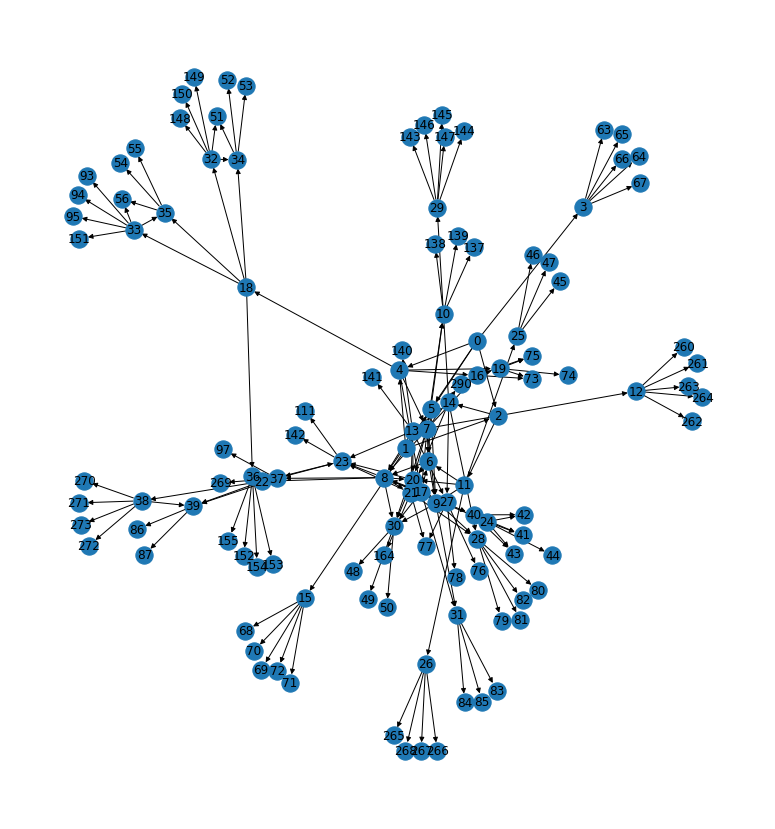

In [10]:
take_n = 200
path_fig = f"assets/graph_viz_n_{take_n}.png"
plot_graph(g.edges, path_fig=path_fig, take_n=take_n)

The ratio between the in and out degrees is the degree ratio. A higher ratio value will tell us where many purchases end (but rarely begin), while a lower value tells us where purchases often begin (but infrequently end).

In [11]:
degree_ratio_df = g.inDegrees.join(g.outDegrees, "id", "outer").selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio")
degree_ratio_df.orderBy(desc("degreeRatio")).show(10)

21/10/21 21:46:38 WARN TaskSetManager: Stage 14 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:39 WARN TaskSetManager: Stage 15 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+-----------+
|   id|degreeRatio|
+-----+-----------+
|14949|       84.0|
| 4429|       80.8|
|   33|       72.2|
|10519|       66.8|
|12771|       66.0|
|    8|       58.6|
| 3910|       55.0|
|  481|       55.0|
| 5737|       54.4|
| 9106|       45.4|
+-----+-----------+
only showing top 10 rows



In [12]:
degrees_df = \
    g.degrees.\
    join(g.inDegrees, "id", "outer").\
    join(g.outDegrees, "id", "outer").\
    join(degree_ratio_df, "id", "outer").\
    drop(g.outDegrees.id).\
    drop(g.inDegrees.id).\
    drop(degree_ratio_df.id).\
    na.fill(0)

degrees_df.sort(desc("degree")).show()

21/10/21 21:46:41 WARN TaskSetManager: Stage 17 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:41 WARN TaskSetManager: Stage 18 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:42 WARN TaskSetManager: Stage 20 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+--------+---------+-----------+
|   id|degree|inDegree|outDegree|degreeRatio|
+-----+------+--------+---------+-----------+
|14949|   425|     420|        5|       84.0|
| 4429|   409|     404|        5|       80.8|
|   33|   366|     361|        5|       72.2|
|10519|   339|     334|        5|       66.8|
|12771|   335|     330|        5|       66.0|
|    8|   298|     293|        5|       58.6|
|  481|   280|     275|        5|       55.0|
|  297|   280|     280|        0|        0.0|
| 5737|   277|     272|        5|       54.4|
| 9106|   232|     227|        5|       45.4|
| 8939|   226|     221|        5|       44.2|
|   93|   224|     219|        5|       43.8|
| 1241|   223|     218|        5|       43.6|
| 5765|   214|     209|        5|       41.8|
| 2501|   196|     191|        5|       38.2|
|   99|   193|     188|        5|       37.6|
| 3661|   186|     181|        5|       36.2|
| 2353|   184|     179|        5|       35.8|
|  244|   184|     179|        5| 

In [13]:
# Convert degree GraphFrames to lists for plotting.
degrees_list = [int(d.degree) for d in degrees_df.select('degree').collect()]
in_degree_list = [int(d.inDegree) for d in degrees_df.select('inDegree').collect()]
out_degree_list = [int(d.outDegree) for d in degrees_df.select('outDegree').collect()]

21/10/21 21:46:46 WARN TaskSetManager: Stage 24 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:47 WARN TaskSetManager: Stage 25 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:47 WARN TaskSetManager: Stage 27 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:52 WARN TaskSetManager: Stage 31 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:53 WARN TaskSetManager: Stage 32 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:53 WARN TaskSetManager: Stage 34 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:46:55 WARN TaskSetManager: Stage 35 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/

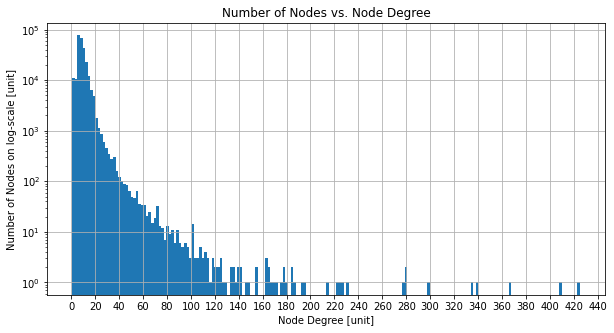

In [14]:
x = degrees_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Degree [unit]"
title = "Number of Nodes vs. Node Degree"
save_path = "assets/n_nodes_vs_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

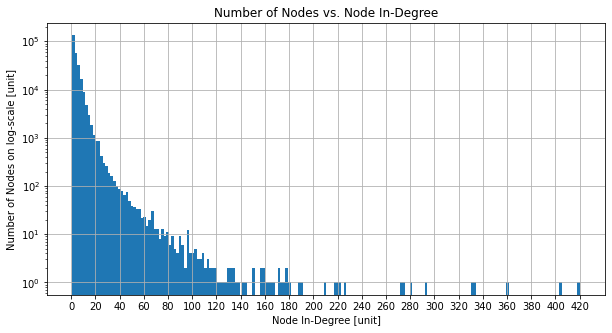

In [15]:
x = in_degree_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node In-Degree [unit]"
title = "Number of Nodes vs. Node In-Degree"
save_path = "assets/n_nodes_vs_in_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

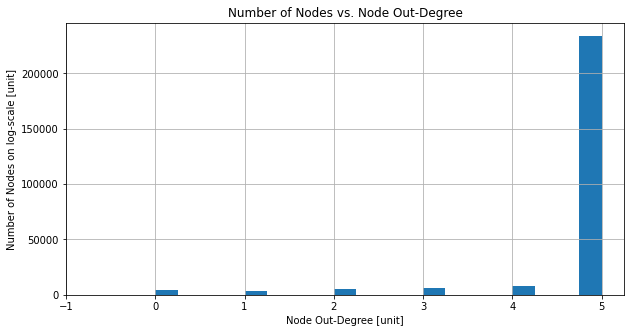

In [16]:
x = out_degree_list
n_bins = 20
x_step = 1
yscale = "linear"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Out-Degree [unit]"
title = "Number of Nodes vs. Node Out-Degree"
save_path = "assets/n_nodes_vs_out_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

## Quantitative Graph Analysis: Motifs, Triangles, PageRank, Label Propagation, and Jaccard Similarity

### Motif Finding

Use  GraphFrames motifs (sort of reg-ex on graphs) to find mutually co-purchased products, i.e.:  a<->mutual<->c node structure

In [17]:
# b is mutually copurchased with a and c
mutually_copurchased_products_df = g.find("(a)-[]->(mutual); (mutual)-[]->(c); (c)-[]->(mutual); (mutual)-[]->(a)").dropDuplicates()
mutually_copurchased_products_df.show()

21/10/21 21:47:08 WARN TaskSetManager: Stage 58 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:09 WARN TaskSetManager: Stage 48 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:10 WARN TaskSetManager: Stage 49 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:14 WARN TaskSetManager: Stage 53 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:19 WARN TaskSetManager: Stage 56 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+
|                   a|              mutual|                   c|
+--------------------+--------------------+--------------------+
|{3656, Trouble wi...|{2777, Starting W...|{2773, The Diabet...|
|{20006, GIRLS TO ...|{21752, The Hidde...|{39066, Pagan Kid...|
|{29655, How to Dr...|{22965, The Exist...|{29653, Cape May ...|
|{32555, Macromedi...|{32557, All the R...|{32556, Comigo - ...|
|{52531, Live Psal...|{38877, Red Smith...|{52532, An Atlas ...|
|{108011, Eyewitne...|{41110, A Perfect...|{108011, Eyewitne...|
|{43387, Samoyed C...|{43388, John D. R...|{48744, In My Lif...|
|{80655, Relativit...|{44094, Magic Mir...|{24749, Disintegr...|
|{68477, The Shy C...|{44472, Race, Cla...|{68477, The Shy C...|
|{40398, Poem of t...|{47306, What's Co...|{61235, An Elusiv...|
|{50857, Sair Linu...|{50859, Brian's S...|{50858, Don't Die...|
|{48241, The Sunsh...|{65144, Sun Kisse...|{65145, Live Set,...|
|{63877, Coral Fis...|{71

### Traingle Count

Traingle counts for finding important products.

In [18]:
g.triangleCount().show()

21/10/21 21:47:37 WARN TaskSetManager: Stage 62 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:38 WARN TaskSetManager: Stage 63 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:39 WARN TaskSetManager: Stage 65 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:45 WARN TaskSetManager: Stage 70 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+----+--------------------+-----+---------+-------+
|count|  id|               title|group|salesrank|reviews|
+-----+----+--------------------+-----+---------+-------+
|   19|  26|      Chicken Little| book|   242571|    4.0|
|   48|  29|Advanced Pediatri...| book|   677416|    0.0|
|    0| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
|    2| 964|Outsmarting the S...| book|   536872|    4.5|
|   17|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|    1|1697|Experiences in Mo...| book|   695386|    0.0|
|   24|1806|Black Stallion an...| book|    71706|    5.0|
|   10|1950|Applied Blood Gro...| book|   985020|    5.0|
|    6|2040|The Minority Repo...| book|   326911|    4.5|
|   21|2214|The Arts of the S...| book|   923205|    4.0|
|    6|2250|         Yummy Yummy|music|   170306|    4.5|
|    3|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|    4|2509|Girls, Delinquenc...| book|   559169|    5.0|
|   23|2529|When You look Lik...| book|   667405|    5.0|
|    4|2927|Th

### PageRank

Pagreank algorithm to find the most important prroduct.

In [19]:
pagerank = g.pageRank(resetProbability=0.15, maxIter=5) #maxIter=5

21/10/21 21:47:54 WARN TaskSetManager: Stage 77 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:58 WARN TaskSetManager: Stage 76 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:47:59 WARN TaskSetManager: Stage 78 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:05 WARN TaskSetManager: Stage 82 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:08 WARN TaskSetManager: Stage 84 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:08 WARN TaskSetManager: Stage 94 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:09 WARN TaskSetManager: Stage 96 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/

In [20]:
pagerank.vertices.orderBy("pagerank", ascending=False).show()

21/10/21 21:48:15 WARN TaskSetManager: Stage 197 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+----+--------------------+-----+---------+-------+------------------+
|  id|               title|group|salesrank|reviews|          pagerank|
+----+--------------------+-----+---------+-------+------------------+
|  33|Double Jeopardy (...| book|    97166|    5.0|  256.865019479512|
|  93|BizPricer¿ Busine...| book|  1485593|    0.0|222.28038731548094|
|4429|Harley-Davidson P...| book|   147799|    4.5| 186.2275745547629|
|   8| Losing Matt Shepard| book|   277409|    4.5|184.59950378052676|
|2501|The Narcissistic ...| book|     9727|    5.0|176.16085273457895|
|  94|The American Heri...| book|   166549|    4.0|163.67544518164442|
| 151|Laurel & Hardy - ...|  dvd|    44671|    3.0|163.31819625369937|
|  56|Three Bricks Shy ...| book|  2167012|    0.0|145.49653670139432|
|  95|The Heavy Flak Gu...| book|  1369585|    0.0|144.27429036648198|
|2353|           Committed|music|   437762|    5.0|141.02818514868358|
|9106|A Touch Of Tranqu...|music|    39971|    5.0|120.11337114259695|
| 481|

### Label Propagation Algorithm (LPA) for Recommendation

In [21]:
max_iter = 5 #max_iter = 5
lpa = LabelPropagationAlgorithm(g=g, max_iter=max_iter)

21/10/21 21:48:18 WARN TaskSetManager: Stage 205 contains a task of very large size (1761 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:28 WARN TaskSetManager: Stage 216 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:38 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 21:48:38 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 21:48:38 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 21:48:38 WARN TaskSetManager: Stage 230 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:48:40 WARN MemoryStore: Not enough space to cache rdd_533_7 in memory! (computed 5.3 MiB so far)
21/10/21 21:48:40 WARN BlockManager: Block rdd_533_7 could not be removed as it was not found on disk or in memory
21/10/21

LPA has been fit to graph


In [22]:
lpa.get_communities().show()
n_labels = lpa.get_communities().select("label").distinct().count()
print(f"LPA found {n_labels} labels after {max_iter} iteration(s)")

community_counts = lpa.get_communities().groupBy(col("label")).count().orderBy(desc("count"))
community_counts.show()

21/10/21 21:49:54 WARN TaskSetManager: Stage 292 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:49:56 WARN CacheManager: Asked to cache already cached data.        


+----+--------------------+-----+---------+-------+------+
|  id|               title|group|salesrank|reviews| label|
+----+--------------------+-----+---------+-------+------+
|  26|      Chicken Little| book|   242571|    4.0|   382|
|  29|Advanced Pediatri...| book|   677416|    0.0|   146|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|  8158|
| 964|Outsmarting the S...| book|   536872|    4.5| 60577|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|  6465|
|1697|Experiences in Mo...| book|   695386|    0.0|   831|
|1806|Black Stallion an...| book|    71706|    5.0|  1806|
|1950|Applied Blood Gro...| book|   985020|    5.0|  1207|
|2040|The Minority Repo...| book|   326911|    4.5|  2039|
|2214|The Arts of the S...| book|   923205|    4.0|  2111|
|2250|         Yummy Yummy|music|   170306|    4.5|138055|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|  1483|
|2509|Girls, Delinquenc...| book|   559169|    5.0|  1824|
|2529|When You look Lik...| book|   667405|    5.0|  151

21/10/21 21:49:59 WARN CacheManager: Asked to cache already cached data.        


LPA found 45577 labels after 5 iteration(s)


+-----+-----+
|label|count|
+-----+-----+
| 2353|  531|
|  517|  426|
|22073|  234|
| 7153|  223|
|  469|  216|
|  244|  203|
| 5915|  197|
|13218|  195|
| 4937|  157|
| 9668|  153|
| 1964|  147|
| 4841|  136|
| 8517|  124|
|   95|  124|
| 1465|  122|
|95149|  120|
|10709|  111|
|31712|   97|
|92861|   95|
|60311|   95|
+-----+-----+
only showing top 20 rows



Use LPA to get a recommendation for a product.

In [23]:
id_ = 10
g.vertices.filter(f"id = {id_}").show()

recommendations_df = lpa(id_= id_)
recommendations_df.show()

21/10/21 21:50:01 WARN TaskSetManager: Stage 364 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 10|The Edward Said R...| book|   220379|    4.0|
+---+--------------------+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|11700|Middlemarch (Word...| book|  1216188|    4.5|11701|
|11698|Food Folklore : T...| book|   779866|    0.0|11701|
|   10|The Edward Said R...| book|   220379|    4.0|11701|
|11699|Getting to the Be...| book|   552678|    5.0|11701|
| 5554|       The Decameron| book|   441660|    5.0|11701|
|13805|Great Overtures i...| book|   801312|    0.0|11701|
+-----+--------------------+-----+---------+-------+-----+



In [24]:
id_ = 20
g.vertices.filter(f"id = {id_}").show()

recommendations_df = lpa(id_= id_)
recommendations_df.show()

21/10/21 21:50:02 WARN TaskSetManager: Stage 517 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+---+--------------------+-----+---------+-------+
| id|               title|group|salesrank|reviews|
+---+--------------------+-----+---------+-------+
| 20|Computed Tomograp...| book|   179448|    5.0|
+---+--------------------+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|40311|Pure Beauties: Ma...|  dvd|    48332|    3.0|   23|
|  455|Midwinter Night's...|music|    59751|    5.0|   23|
|41826|You Can Depend on...|music|   143305|    5.0|   23|
|77571|            Only Dad| book|   788639|    4.0|   23|
| 7622|Mtv: The Making o...| book|  1303965|    3.5|   23|
|   79|Today's Military ...| book|     7437|    4.5|   23|
| 3549|The Who - Live at...|  dvd|    22672|    4.0|   23|
|   28|God Knows Marriag...| book|   745886|    0.0|   23|
|25867|    Hang On, Hopper!| book|  1116593|    5.0|   23|
|28924|     High School Usa|video|  

In [25]:
id_ = 12345
g.vertices.filter(f"id = {id_}").show()

recommendations_df = lpa(id_= id_)
recommendations_df.show()

21/10/21 21:50:04 WARN TaskSetManager: Stage 670 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+-----+-----+-----+---------+-------+
|   id|title|group|salesrank|reviews|
+-----+-----+-----+---------+-------+
|12345| Maya|music|    64984|    5.0|
+-----+-----+-----+---------+-------+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|10510|Tristana (Easy Re...| book|   991608|    4.0|10508|
|12345|                Maya|music|    64984|    5.0|10508|
|13137|Beggar's Ride (Be...| book|   322234|    3.0|10508|
|10509|Tchaikovsky: Pian...|music|    76777|    4.5|10508|
|17238|      Q's Jook Joint|music|     5440|    4.5|10508|
|12344|The Use and Abuse...| book|   581060|    0.0|10508|
|10512|SQ : Connecting W...| book|   354885|    4.0|10508|
|10508|The V Zone : A Wo...| book|   352991|    5.0|10508|
|18289|The Dictionary of...| book|   163207|    3.5|10508|
| 5381|Noah'S Ark (Littl...| book|   399319|    5.0|10508|
+-----+--------------------+-----+--------

### Jaccard Similarity for Recommendation

In [26]:
jsp = JaccardSimilarity(g=g, id_=10, spark=spark)
vertices_similar_df = jsp()
vertices_similar_df.show()

21/10/21 21:50:05 WARN TaskSetManager: Stage 825 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:06 WARN TaskSetManager: Stage 824 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:06 WARN TaskSetManager: Stage 828 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:09 WARN TaskSetManager: Stage 834 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:09 WARN TaskSetManager: Stage 833 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:10 WARN TaskSetManager: Stage 837 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:12 WARN TaskSetManager: Stage 842 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.

+---+--------------------+-----+---------+-------+-------------------+
| id|               title|group|salesrank|reviews|            jaccard|
+---+--------------------+-----+---------+-------+-------------------+
|139|  The Sacred Impulse| book|   846457|    3.0|0.42857142857142855|
|137|Apples of Gold: A...| book|   129355|    5.0|0.42857142857142855|
|  5|Prayers That Avai...| book|   455160|    0.0| 0.1111111111111111|
|  7|               Batik|music|     5392|    4.5| 0.1111111111111111|
|138|The McClurkin Pro...|music|    54277|    4.0|                0.0|
+---+--------------------+-----+---------+-------+-------------------+



In [27]:
jsp = JaccardSimilarity(g=g, id_=20, spark=spark)
vertices_similar_df = jsp()
vertices_similar_df.show()

21/10/21 21:50:26 WARN TaskSetManager: Stage 882 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:26 WARN TaskSetManager: Stage 884 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:27 WARN TaskSetManager: Stage 886 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:29 WARN TaskSetManager: Stage 891 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:30 WARN TaskSetManager: Stage 894 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:31 WARN TaskSetManager: Stage 895 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:32 WARN TaskSetManager: Stage 900 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.

+---+--------------------+-----+---------+-------+------------------+
| id|               title|group|salesrank|reviews|           jaccard|
+---+--------------------+-----+---------+-------+------------------+
|  7|               Batik|music|     5392|    4.5|              0.25|
|  6|How the Other Hal...| book|   188784|    4.0|              0.25|
|  8| Losing Matt Shepard| book|   277409|    4.5|0.1111111111111111|
| 30|Solving Statics P...| book|   227883|    0.0|0.1111111111111111|
| 23|Strange Fire: A N...| book|  1277867|    3.0|0.1111111111111111|
+---+--------------------+-----+---------+-------+------------------+



In [28]:
jsp = JaccardSimilarity(g=g, id_=12345, spark=spark)
vertices_similar_df = jsp()
vertices_similar_df.show()

21/10/21 21:50:47 WARN TaskSetManager: Stage 939 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:48 WARN TaskSetManager: Stage 943 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:49 WARN TaskSetManager: Stage 945 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:50 WARN TaskSetManager: Stage 949 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:51 WARN TaskSetManager: Stage 951 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:52 WARN TaskSetManager: Stage 954 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 21:50:53 WARN TaskSetManager: Stage 958 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.

+-----+--------------------+-----+---------+-------+------------------+
|   id|               title|group|salesrank|reviews|           jaccard|
+-----+--------------------+-----+---------+-------+------------------+
|13137|Beggar's Ride (Be...| book|   322234|    3.0|0.2857142857142857|
|17238|      Q's Jook Joint|music|     5440|    4.5|0.2857142857142857|
|12344|The Use and Abuse...| book|   581060|    0.0|0.2857142857142857|
|10510|Tristana (Easy Re...| book|   991608|    4.0|             0.125|
+-----+--------------------+-----+---------+-------+------------------+



## Clean Up

Clean up data/

In [29]:
"""%%bash
file=./data/amazon0302.txt.gz
file_txt=./data/amazon0302.txt
meta=./data/amazon-meta.txt.gz
meta_txt=./data/amazon-meta.txt
rm $file
rm $file_txt
rm $meta
rm $meta_txt"""

'%%bash\nfile=./data/amazon0302.txt.gz\nfile_txt=./data/amazon0302.txt\nmeta=./data/amazon-meta.txt.gz\nmeta_txt=./data/amazon-meta.txt\nrm $file\nrm $file_txt\nrm $meta\nrm $meta_txt'

## Sources

https://graphframes.github.io/graphframes/docs/_site/user-guide.html

https://docs.databricks.com/_static/notebooks/graphframes-user-guide-py.html

https://towardsdatascience.com/graphframes-in-jupyter-a-practical-guide-9b3b346cebc5

https://graphframes.github.io/graphframes/docs/_site/api/python/index.html